In [503]:
import pandas as pd
import numpy as np
import quandl
from datetime import datetime, timedelta
import json
import matplotlib.pyplot as plt


from dateutil.parser import parse
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import log_loss, precision_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_auc_score, f1_score, make_scorer, recall_score, average_precision_score
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.fixes import signature
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


In [480]:
# pull in cleaned dataset

data = pd.read_csv('data/combined_clean.csv', low_memory=False)

In [481]:
data.head()

,Unnamed: 0,ticker_symbol,co_name,unique_earnings_code,factset_sector_num,factset_ind_num,calendar_qtr,fiscal_qtr,adtv_prev_month,report_date,...,si_days_1m_delta_F,si_days_3m_delta_F,si_pct_1m_delta_F,si_pct_3m_delta_F,3m_delta_an_rtg_F,pre_rpt_rtn_to_tgt_F,3m_delta_tgt_px_F,1m_est_delta_F,3m_est_delta_F,proj_2yr_rev_gr_F
0,0,RAMP,"LiveRamp Holdings, Inc.",RAMP.1Q14,3300.0,3305.0,1Q14,2013/4F,14.4,05/15/2014,...,-0.144062,0.496136,0.057002,0.172538,0.15,33.83,4.44,1.266,7.527,-2.946171
1,2,TCO,"Taubman Centers, Inc.",TCO.1Q14,4800.0,4890.0,1Q14,2014/1F,37.3,04/25/2014,...,0.352543,0.223015,0.171640,0.150831,0.00,2.49,-0.10,-2.722,-3.706,-2.351877
2,5,SNX,SYNNEX Corporation,SNX.1Q14,3250.0,3265.0,1Q14,2014/1F,17.4,04/04/2014,...,0.000000,0.457639,0.069347,0.973769,-0.20,15.84,-5.39,1.198,-7.997,20.412552
3,7,AIV,Apartment Investment and Management Company Cl...,AIV.1Q14,4800.0,4890.0,1Q14,2014/1F,62.7,05/02/2014,...,0.582350,0.547657,-0.160877,-0.058043,0.07,2.13,-2.40,43.314,-3.597,-5.047765
4,10,IT,"Gartner, Inc.",IT.1Q14,3200.0,3205.0,1Q14,2014/1F,51.1,05/01/2014,...,0.015320,-0.107287,-0.218061,-0.025564,0.04,7.41,0.97,-0.270,-22.105,21.560045


In [565]:
def encode_sectors(filename):
    """Encodes factset_sector_num as binary categorical columns and writes them to the csv file
    with 'trailing F' notation."""
    data = pd.read_csv('data/'+str(filename)+'.csv', low_memory=False)
    data.drop(columns='Unnamed: 0', inplace=True)
    
    enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
    sectors = data.factset_sector_num.values
    sectors = sectors.reshape(-1, 1)
    encoded_cols = enc.fit_transform(sectors)
    feature_labels = list(enc.get_feature_names())
    feature_names = []
    
    for item in feature_labels:
        tagged_name = item+'_F'
        feature_names.append(tagged_name)
    
    temp = pd.DataFrame(encoded_cols, columns=feature_names)
    data = pd.concat([data, temp], axis=1)
    # write combined_df to a csv file and store in data folder
    data.to_csv('data/'+str(filename)+'.csv')
    
    return

In [566]:
encode_sectors('combined_clean')

In [6]:
def transform_dates(df, col_name):
    """Helper function to convert date columns to a sortable format"""
    dates = list(df[str(col_name)])
    new_dates = []

    for d in dates:
        dt = datetime.strptime(d, '%m/%d/%Y')
        reformatted = str(dt)
        reformatted = reformatted[:10]
        new_dates.append(reformatted)
        
    df[str(col_name)] = new_dates    

In [614]:
def oos_partition(filename):
    data = pd.read_csv('data/'+str(filename)+'.csv', low_memory=False)
    data.drop(columns='Unnamed: 0', inplace=True)
    
    # reformat dates and sort by dates, ascending
    transform_dates(data, 'report_date')
    data.sort_values(by=['report_date'], inplace=True)
    
    # set index to unique_earnings_code
    data.set_index('unique_earnings_code', inplace=True)
    # partition 3q18 data to test set
    test_partition = data[data.index.str.endswith('3Q18')]
    test_partition.to_csv('data/oos_data_partition.csv')
    
    # create y_oos array
    y_oos = test_partition.targets.values
    
    # create X_oos array
    features = test_partition.columns.str.endswith('F')
    X_oos = test_partition.values[:,features]
    
    # remove test_partition from data df
    data = data[data.index.str.endswith('3Q18') == False]
    
    # create y_train and X_train arrays
    y = data.targets.values
    X = data.values[:,features]
    
     
    return X, X_oos, y, y_oos


In [615]:
oos_partition('combined_clean')

(array([[91.93925, 22.510983, -1.4428675, ..., 0.0, 0.0, 0.0],
        [99.958244, 22.77716400000001, -4.4017019999999984, ..., 0.0, 0.0,
         0.0],
        [8.037508, -4.144144, 2.4860144, ..., 0.0, 0.0, 0.0],
        ...,
        [-18.429005, -20.014309, -3.7600517, ..., 0.0, 0.0, 0.0],
        [30.654919, 2.9359102000000004, -4.442036, ..., 0.0, 0.0, 0.0],
        [56.21791775000001, 59.477867, 12.340093, ..., 0.0, 0.0, 0.0]],
       dtype=object),
 array([[18.727493, 5.933118, -1.7017066000000003, ..., 0.0, 0.0, 0.0],
        [17.889977, 8.763647, 1.8372774, ..., 0.0, 0.0, 0.0],
        [1.7135501, 2.9136062000000003, 0.7196188, ..., 0.0, 0.0, 0.0],
        ...,
        [-42.90817, -31.847132, -13.360328, ..., 0.0, 0.0, 0.0],
        [-23.55495, -0.9106159, -3.8974702, ..., 0.0, 0.0, 0.0],
        [22.862602, -12.392873, -5.895734, ..., 0.0, 0.0, 0.0]],
       dtype=object),
 array([1, 0, 0, ..., 0, 1, 1]),
 array([0, 0, 0, ..., 1, 0, 0]))

In [619]:
def prepare_partitions(filename, test_slice=0.25, rand_seed=1970):
    """Partitions 3Q18 data for out of sample validation and creates train-test split on remainder. 
            * Writes 3Q18 df to a file in the data folder: oos_data_partition.csv
            * Creates a train-test split on remaining data
            * Returns X_train, X_test, X_oos, y_train, y_test, y_oos
            
        test_slice defaults to 0.25, but can be assigned by keyword
        rand_seed defaults to 1970, but can be assigned by keyword
    """
    
    X, X_oos, y, y_oos = oos_partition(filename)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_slice, random_state=rand_seed)
    
    return X_train, X_test, X_oos, y_train, y_test, y_oos

In [620]:
X_train, X_test, X_oos, y_train, y_test, y_oos = prepare_partitions('combined_clean')

In [627]:
len(X_test)

6498

### FSM

In [610]:
X, X_oos, y, y_oos, features = oos_partition('combined_clean')

In [590]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1970)

In [611]:
X_oos

array([[18.727493, 5.933118, -1.7017066000000003, ..., 0.0, 0.0, 0.0],
       [17.889977, 8.763647, 1.8372774, ..., 0.0, 0.0, 0.0],
       [1.7135501, 2.9136062000000003, 0.7196188, ..., 0.0, 0.0, 0.0],
       ...,
       [-42.90817, -31.847132, -13.360328, ..., 0.0, 0.0, 0.0],
       [-23.55495, -0.9106159, -3.8974702, ..., 0.0, 0.0, 0.0],
       [22.862602, -12.392873, -5.895734, ..., 0.0, 0.0, 0.0]],
      dtype=object)

In [591]:
clf = RandomForestClassifier(n_estimators=500, 
                             criterion='entropy',
                             max_features=5,
                             max_depth=6,
                             random_state=1970)

In [592]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=6, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=1970, verbose=0,
            warm_start=False)

In [199]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1970)

In [593]:
y_pred = clf.predict_proba(X_test)

In [249]:
cv_log_loss = cross_val_score(clf, # model
                             X_train, # Feature matrix
                             y_train, # Target vector
                             cv=skf, # Cross-validation technique
                             scoring=make_scorer(recall_score), # Loss function
                             n_jobs=-1) # Use all CPU scores

array([0., 0., 0., 0., 0.])

In [599]:
hard_classes = create_hard_classes(y_pred,0.07)

In [573]:
tn, fp, fn, tp = confusion_matrix(y_test, hard_classes).ravel()

In [594]:
def calc_profit_curve(y_test, y_predict, max_threshold):
    thresholds = []
    results = []
    for i in range(0, max_threshold+1):
        thresh = float(i/100)
        hard_classes = create_hard_classes(y_predict, thresh)
        tn, fp, fn, tp = confusion_matrix(y_test, hard_classes).ravel()
        profit = (5*tp*0.09)+(5*fp*-0.005)
        thresholds.append(i)
        result_entry = [tp, fp, profit]
        results.append(result_entry)
        
    return dict(zip(thresholds, results))
        
    

In [595]:
profits = calc_profit_curve(y_test, y_pred, 22)

In [596]:
profits

{0: [450, 6048, 51.29999999999998],
 1: [450, 6048, 51.29999999999998],
 2: [450, 6048, 51.29999999999998],
 3: [450, 6048, 51.29999999999998],
 4: [450, 6048, 51.29999999999998],
 5: [441, 5614, 58.099999999999994],
 6: [392, 4126, 73.25],
 7: [266, 2053, 68.37499999999999],
 8: [148, 888, 44.39999999999999],
 9: [80, 418, 25.549999999999997],
 10: [40, 198, 13.05],
 11: [20, 84, 6.9],
 12: [6, 26, 2.05],
 13: [1, 6, 0.29999999999999993],
 14: [0, 0, 0.0],
 15: [0, 0, 0.0],
 16: [0, 0, 0.0],
 17: [0, 0, 0.0],
 18: [0, 0, 0.0],
 19: [0, 0, 0.0],
 20: [0, 0, 0.0],
 21: [0, 0, 0.0],
 22: [0, 0, 0.0]}

In [600]:
recall_score(y_test, hard_classes, labels=class_list)

0.5911111111111111

In [601]:
precision_score(y_test, hard_classes, labels=class_list)

0.11470461405778352

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.10')

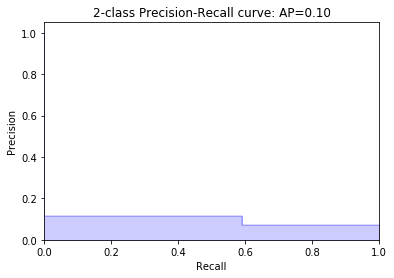

In [602]:
average_precision = average_precision_score(y_test, hard_classes)
precision, recall, _ = precision_recall_curve(y_test, hard_classes)

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [239]:
class_list = ['no_signal', 'signal']

### Gradient Boosting Classifier

In [603]:
gb_clf = GradientBoostingClassifier(n_estimators=3000,
                                    learning_rate=0.01, 
                                    max_depth=2,
                                    subsample = 0.5,
                                    random_state=1970)

In [604]:
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=3000,
              n_iter_no_change=None, presort='auto', random_state=1970,
              subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [605]:
gb_y_pred = gb_clf.predict_proba(X_test)

In [606]:
log_loss(y_test, gb_clf.predict(X_test))

2.4131436875468104

In [607]:
profits = calc_profit_curve(y_test, gb_y_pred, 40)

In [458]:
len(X_test)

6498

In [608]:
profits

{0: [450, 6048, 51.29999999999998],
 1: [450, 6044, 51.400000000000006],
 2: [447, 5838, 55.19999999999999],
 3: [424, 4985, 66.17499999999998],
 4: [388, 3908, 76.89999999999999],
 5: [347, 2973, 81.825],
 6: [288, 2219, 74.125],
 7: [237, 1725, 63.52499999999999],
 8: [200, 1365, 55.875],
 9: [173, 1081, 50.82499999999999],
 10: [151, 874, 46.1],
 11: [136, 734, 42.849999999999994],
 12: [121, 616, 39.05],
 13: [109, 521, 36.025],
 14: [90, 451, 29.225],
 15: [80, 390, 26.25],
 16: [67, 329, 21.924999999999997],
 17: [55, 278, 17.8],
 18: [45, 240, 14.25],
 19: [39, 208, 12.350000000000001],
 20: [30, 176, 9.1],
 21: [26, 155, 7.824999999999999],
 22: [23, 126, 7.199999999999999],
 23: [18, 112, 5.299999999999999],
 24: [17, 99, 5.174999999999999],
 25: [13, 88, 3.6499999999999995],
 26: [12, 76, 3.499999999999999],
 27: [8, 67, 1.9249999999999996],
 28: [7, 58, 1.7],
 29: [6, 46, 1.5499999999999996],
 30: [5, 40, 1.25],
 31: [4, 36, 0.8999999999999998],
 32: [4, 32, 0.99999999999999

In [365]:
precision_score(y_test, gb_hard_classes)

0.10874200426439233

In [366]:
confusion_matrix(y_test, gb_hard_classes)

array([[5630,  418],
       [ 399,   51]])

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.07')

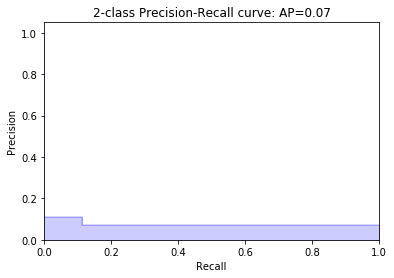

In [367]:
average_precision = average_precision_score(y_test, gb_hard_classes)
precision, recall, _ = precision_recall_curve(y_test, gb_hard_classes)

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [195]:
# The scorers can be either be one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
scoring = {'AUC': 'roc_auc', 'F1 Score': make_scorer(f1_score)}

# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_params_`` and
# ``gs.best_index_``
gs = GridSearchCV(clf,
                  param_grid={'max_features': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
                              'max_depth': [4, 6, 8, 10]},
                  scoring=scoring, cv=5, refit='AUC', return_train_score=True)
gs.fit(X_train, y_train)
results = gs.cv_results_

/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-pac

/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-pac

/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-pac

/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-pac

/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-pac

/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-pac

/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-pac

/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-pac

/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-pac

/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jlewis425/anaconda3/lib/python3.6/site-pac

In [196]:
results

{'mean_fit_time': array([ 6.37264128,  7.93529797,  9.30171242, 10.64247484, 11.76187057,
        13.12347431, 14.47833819, 16.33346019, 17.25579076, 18.63556652,
         8.92649817, 10.95748754, 12.93932805, 14.96968627, 16.99970264,
        20.78723435, 21.00353785, 24.62324409, 26.83470602, 29.56598225,
        12.54938874, 14.8214416 , 16.81744766, 19.45754199, 22.10045481,
        24.74887285, 27.45418005, 30.09971538, 32.7082305 , 35.37590485,
        13.72862563, 16.99446878, 20.14159369, 23.96873989, 26.46072545,
        29.70995073, 32.8712646 , 36.27545776, 39.34362798, 44.39232907]),
 'std_fit_time': array([0.09229146, 0.16076735, 0.10327206, 0.27154156, 0.01234623,
        0.02692848, 0.01708907, 0.58224582, 0.02179443, 0.033145  ,
        0.02323617, 0.03266086, 0.02422385, 0.02923594, 0.06916461,
        1.53932103, 0.05860171, 0.9566572 , 0.96891001, 0.64841861,
        0.30661106, 0.71236173, 0.0625188 , 0.05355208, 0.05170624,
        0.11189074, 0.1766788 , 0.1198020

In [149]:

feature_columns = data.columns[features]

In [150]:
feature_columns

Index(['lt_mome_F', '3m_mome_F', '1m_mome_F', 'pre_rpt_si_days_F',
       'pre_rpt_si_pct_F', 'pre_rpt_an_rtg_F', 'pre_rpt_an_rtg_sd_F',
       'eps_yld_F', 'mult_exp_F', 'rel_lt_mome_F', 'rel_3m_mome_F',
       'rel_1m_mome_F', 'si_days_1m_delta_F', 'si_days_3m_delta_F',
       'si_pct_1m_delta_F', 'si_pct_3m_delta_F', '3m_delta_an_rtg_F',
       'pre_rpt_rtn_to_tgt_F', '3m_delta_tgt_px_F', '1m_est_delta_F',
       '3m_est_delta_F', 'proj_2yr_rev_gr_F'],
      dtype='object')

In [151]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = feature_columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [152]:
feature_importances

,importance
pre_rpt_si_pct_F,0.067051
proj_2yr_rev_gr_F,0.058305
pre_rpt_rtn_to_tgt_F,0.050846
si_pct_3m_delta_F,0.050359
lt_mome_F,0.050313
rel_lt_mome_F,0.050043
3m_est_delta_F,0.048179
si_pct_1m_delta_F,0.046914
si_days_3m_delta_F,0.046801
eps_yld_F,0.045712


In [163]:
print(y_pred)

[[0.97222193 0.02425115 0.00352692]
 [0.95536857 0.02561968 0.01901176]
 [0.93328931 0.05373091 0.01297978]
 ...
 [0.87481445 0.0840554  0.04113016]
 [0.89010208 0.08529911 0.02459881]
 [0.75844913 0.11507253 0.12647834]]


In [78]:
print(y_train)

[0 0 0 ... 0 0 0]


In [164]:
predicted_0 = y_pred[:,0]
predicted_1 = y_pred[:,1]
predicted_2 = y_pred[:,2]

In [165]:
sum(predicted_0)

3557.1330757943

In [166]:
signal_1 = (predicted_1 > 0.20)

In [167]:
sum(signal_1)

40

In [168]:
signal_0 = predicted_0 > 0.20

In [169]:
sum(signal_0)

3898

In [170]:
signal_2 = predicted_2 > 0.20

In [171]:
sum(signal_2)

3

In [173]:
hard_classes = interpret_predictions(y_pred)

In [ ]:
confusion_matrix()

In [85]:
data = data[data.index.str.endswith('3Q18') == False]

In [86]:
big_moves = data.extreme_targets.values

In [87]:
big_moves

array([0, 0, 0, ..., 0, 1, 0])

In [102]:
precision_score(y_train, hard_classes, average='micro')

0.9890222632604904

In [89]:
def _predict_ones(array):
    output = []
    for i in array:
        if i == 1:
            output.append(1)
        else:
            output.append(0)
    return np.array(output)

In [92]:
one_predictions = _predict_ones(hard_classes)

In [93]:
target_ones = _predict_ones(y_train)

In [234]:
def create_hard_classes(prob_array, threshold):
    hard_classes = []
    for row in prob_array:
        if row[1] >= threshold:
            hard_classes.append(1)
        else:
            hard_classes.append(0)
    return hard_classes
            

In [105]:
hard_classes = np.array(interpret_predictions(y_pred))

In [108]:
accurate_classifications = hard_classes == y_train

In [109]:
print(accurate_classifications)

[ True  True  True ...  True  True  True]


In [110]:
len(accurate_classifications)

19494

In [115]:
wrong_classifications = accurate_classifications[accurate_classifications == False]

In [116]:
len(wrong_classifications)

214

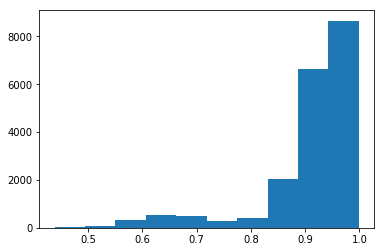

In [99]:
_ = plt.hist(predicted_0)

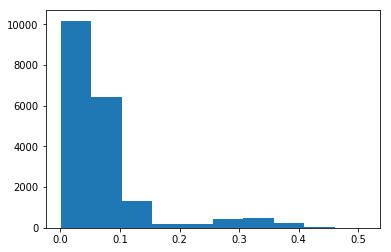

In [100]:
_ = plt.hist(predicted_1)

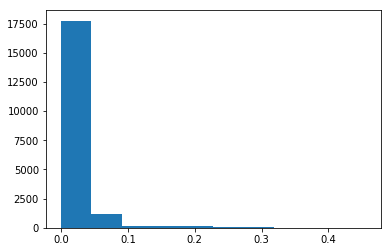

In [101]:
_ = plt.hist(predicted_2)

In [206]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


### Experimenting with Quancha API 

In [ ]:
def add_vol_slope(df):
    """docstring"""
    
    # quandl authentication
    quandl.ApiConfig.api_key = "jUKZLy5xi7gGFf3sSF-r"
    
    

In [ ]:
quandl.ApiConfig.api_key = "jUKZLy5xi7gGFf3sSF-r"

In [ ]:
toy = data.iloc[:25,:]

In [ ]:
toy

In [ ]:
dates = list(toy['report_date'])

In [ ]:
dates[0]

In [ ]:
dt = datetime.strptime(dates[0], '%m/%d/%Y')
str(dt)

In [ ]:
new_dates = []

for d in dates:
    dt = datetime.strptime(d, '%m/%d/%Y')
    reformatted = str(dt)
    reformatted = reformatted[:10]
    new_dates.append(reformatted)





In [ ]:
new_dates